In [35]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [36]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

import torchvision.models as models

In [37]:
device = 'cuda' # 학습시 gpu 사용을 결정, (cuda : gpu 사용, cpu : cpu 사용)
batch_size = 32 # batch size 결정
num_workers = 4 # gpu 사용 시 사용 효율과 관련됨. 무조건 크다고 좋지 않음, system 의존
lr = 1e-3 # learning rate
momentum = 0.9 # optimizer momentum parameter
weight_decay = 1e-5 # weight decay rate
EPOCH = 10 # train epoch
n_steps = 10000

In [38]:
from torch.utils.data import DataLoader, RandomSampler

"""
Image Resize & array to tensor & 증강
train set에만 적용한다. 
test는 unseen 이라고 가정되기때문에 어떤 변화든 줄 수 없음.
"""
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((128, 128)), #image resize
    transforms.RandomHorizontalFlip(), # image Horizontal Flip 
    transforms.RandomChoice([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2), # color transform
        transforms.RandomResizedCrop(128), 
        transforms.RandomAffine(
            degrees=5, translate=(0.5, 0.5),
            scale=(0.8, 1.0), shear=5) # random 하게 이미지 변형
    ]),
    transforms.ToTensor(), # tensor type으로 변경
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)), # image normalize
]),
    'test': transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)),
])
}

# torch datasets 사용하여 image folder로부터 dataset 객체를 생성한다.
train_dataset = datasets.ImageFolder('dataset/train', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder('dataset/test', transform=data_transforms['test'])

# dataset 에서 data를 어떻게 sampling 할지 결정함.

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)


# 실제 학습 시 dataset에서 batch 단위로 갖고오도록 하는 DataLoader 를 생성하여 
# 이전에 설정한 dataset, sampler를 인자로 넣어준다.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)

# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
#                              shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
# print(len(test_dataset))

2663


Size of train set: 2663
Input shape: torch.Size([3, 128, 128])
Label: 0


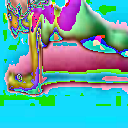

In [39]:
# Let's take a look at train dataset
# 임의의 index를 부여하여 dataset 내 image가 어떻게 변경이 되었는지 확인한다.
print(f"Size of train set: {len(train_dataset)}")
index = 0
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [40]:
from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # ResNet18을 사용하여 encoder 구성
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]  # 마지막 fully connected layer 제외
        self.encoder = nn.Sequential(*modules)
        
        # encoder의 출력 크기를 가져와서 fully connected layer 구성
        n_channels = resnet.fc.in_features
           
        self.enc_out = nn.Sequential(
            nn.Linear(n_channels, 1024),
            nn.BatchNorm1d(1024, momentum=0.01),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256, momentum=0.01),
            nn.ReLU(True))
        
        self.mu = nn.Linear(256, latent_dim*2)
        self.logvar = nn.Linear(256, latent_dim*2)
        
        
        # decoder를 ResNet 구조와 유사한 형태로 구성
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True)
        )
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2),
                               padding=(0, 0)),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=(3,3), stride=(2,2),
                               padding=(0, 0)),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=(3,3), stride=(2,2),
                               padding=(0, 0)),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        x = self.decoder(z)
        x = x.view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear')
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x_enc = self.enc_out(x)

        mu, logvar = self.mu(x_enc), self.logvar(x_enc)
        
        z = self.reparameterize(mu, logvar)
        x_recon  =self.decode(z)

        return x_recon, mu, logvar




In [41]:
def vae_loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
# 모델 학습
# latent_dim 40으로 설정
model = VAE(latent_dim=64).to(device)
# optimizer 생성
# Adam 사용, learning rate, weight_decay 등 위에서 설정한 parameter 적용한다.
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# Train scheduler 설정, cosine Annealing 방식으로 learning rate에 주기를 부여한다.
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# EPOCH & step 1 epoch 당 10000개의 step 존재
# 500 Step 당 loss 확인,
for epoch in range(EPOCH):
    total_loss = 0
    for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
        model.train()
        x= x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        # KL Divergence Loss 구한다. 원본과 생성 이미지 간의 유사도 
#         loss = vae_loss_function(x_recon, x, mu, logvar)
        loss = torch.mean(torch.pow(x - x_recon, 2)) + torch.mean(torch.exp(logvar) + mu**2 - 1 - logvar)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        # Summary & Eval
        if step % 500 == 0:
            print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}")
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCH, total_loss / len(train_dataloader)))

  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -1226629.75
[Step 1000] train_loss: -1861980.62
[Step 1500] train_loss: -2099094.25
[Step 2000] train_loss: -2501176.25
[Step 2500] train_loss: -2645909.75
[Step 3000] train_loss: -3983187.00
[Step 3500] train_loss: -4351408.50
[Step 4000] train_loss: -5466747.00
[Step 4500] train_loss: -4664121.00
[Step 5000] train_loss: -5186848.50
[Step 5500] train_loss: -4258288.50
[Step 6000] train_loss: -4100148.00
[Step 6500] train_loss: -7456912.50
[Step 7000] train_loss: -7031286.50
[Step 7500] train_loss: -5977013.00
[Step 8000] train_loss: -7560110.00
[Step 8500] train_loss: -7237067.00
[Step 9000] train_loss: -9225717.00
[Step 9500] train_loss: -8423708.00
[Step 10000] train_loss: -9376164.00
Epoch [1/10], Loss: -5142165.3038


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -8521021.00
[Step 1000] train_loss: -10501707.00
[Step 1500] train_loss: -10003966.00
[Step 2000] train_loss: -11451270.00
[Step 2500] train_loss: -11489307.00
[Step 3000] train_loss: -13873993.00
[Step 3500] train_loss: -17345464.00
[Step 4000] train_loss: -17773060.00
[Step 4500] train_loss: -25832074.00
[Step 5000] train_loss: -25555190.00
[Step 5500] train_loss: -20681644.00
[Step 6000] train_loss: -26034996.00
[Step 6500] train_loss: -25632178.00
[Step 7000] train_loss: -19471464.00
[Step 7500] train_loss: -27717354.00
[Step 8000] train_loss: -25316156.00
[Step 8500] train_loss: -7152592.50
[Step 9000] train_loss: -25584894.00
[Step 9500] train_loss: -13196072.00
[Step 10000] train_loss: -27898742.00
Epoch [2/10], Loss: -19047858.1889


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -27396176.00
[Step 1000] train_loss: -18924244.00
[Step 1500] train_loss: -28417380.00
[Step 2000] train_loss: -30474454.00
[Step 2500] train_loss: -16467540.00
[Step 3000] train_loss: -34641972.00
[Step 3500] train_loss: -30639864.00
[Step 4000] train_loss: -43182616.00
[Step 4500] train_loss: -45009472.00
[Step 5000] train_loss: -33634444.00
[Step 5500] train_loss: -42144700.00
[Step 6000] train_loss: -45491828.00
[Step 6500] train_loss: -28084162.00
[Step 7000] train_loss: -9733493.00
[Step 7500] train_loss: -34557024.00
[Step 8000] train_loss: -29446128.00
[Step 8500] train_loss: -34512620.00
[Step 9000] train_loss: -40853424.00
[Step 9500] train_loss: -10231279.00
[Step 10000] train_loss: -49417104.00
Epoch [3/10], Loss: -32322294.9614


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -36477668.00
[Step 1000] train_loss: -41617348.00
[Step 1500] train_loss: -50654408.00
[Step 2000] train_loss: -32229946.00
[Step 2500] train_loss: -44025884.00
[Step 3000] train_loss: -42427268.00
[Step 3500] train_loss: -32539426.00
[Step 4000] train_loss: -36864720.00
[Step 4500] train_loss: -42674832.00
[Step 5000] train_loss: -59015768.00
[Step 5500] train_loss: -32602542.00
[Step 6000] train_loss: -42911060.00
[Step 6500] train_loss: -47705428.00
[Step 7000] train_loss: -35879932.00
[Step 7500] train_loss: -46127192.00
[Step 8000] train_loss: -33029058.00
[Step 8500] train_loss: -57227156.00
[Step 9000] train_loss: -50419460.00
[Step 9500] train_loss: -32912166.00
[Step 10000] train_loss: -47295652.00
Epoch [4/10], Loss: -41004013.7155


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -32062844.00
[Step 1000] train_loss: -52368444.00
[Step 1500] train_loss: -49104932.00
[Step 2000] train_loss: -36242296.00
[Step 2500] train_loss: -44160432.00
[Step 3000] train_loss: -51607528.00
[Step 3500] train_loss: -26330730.00
[Step 4000] train_loss: -47859044.00
[Step 4500] train_loss: -37657624.00
[Step 5000] train_loss: -31712066.00
[Step 5500] train_loss: -39368716.00
[Step 6000] train_loss: -45036872.00
[Step 6500] train_loss: -44637848.00
[Step 7000] train_loss: -54918484.00
[Step 7500] train_loss: -41951392.00
[Step 8000] train_loss: -39686016.00
[Step 8500] train_loss: -45033396.00
[Step 9000] train_loss: -48999036.00
[Step 9500] train_loss: -55366684.00
[Step 10000] train_loss: -36615608.00
Epoch [5/10], Loss: -43748331.5980


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -40389388.00
[Step 1000] train_loss: -43229628.00
[Step 1500] train_loss: -47427304.00
[Step 2000] train_loss: -56687760.00
[Step 2500] train_loss: -45647524.00
[Step 3000] train_loss: -41639988.00
[Step 3500] train_loss: -51435380.00
[Step 4000] train_loss: -49453540.00
[Step 4500] train_loss: -43765928.00
[Step 5000] train_loss: -57731316.00
[Step 5500] train_loss: -52196172.00
[Step 6000] train_loss: -41195600.00
[Step 6500] train_loss: -28443036.00
[Step 7000] train_loss: -38618404.00
[Step 7500] train_loss: -50797612.00
[Step 8000] train_loss: -56055152.00
[Step 8500] train_loss: -47654404.00
[Step 9000] train_loss: -46156524.00
[Step 9500] train_loss: -47558604.00
[Step 10000] train_loss: -55101792.00
Epoch [6/10], Loss: -46308523.3056


  0%|          | 0/10000 [00:00<?, ?it/s]

[Step 500] train_loss: -49945076.00
[Step 1000] train_loss: -44152792.00
[Step 1500] train_loss: -37314856.00
[Step 2000] train_loss: -43091948.00
[Step 2500] train_loss: -46060676.00
[Step 3000] train_loss: -50709448.00
[Step 3500] train_loss: -44659460.00
[Step 4000] train_loss: -43175836.00
[Step 4500] train_loss: -45244536.00
[Step 5000] train_loss: -58471544.00
[Step 5500] train_loss: -48317092.00
[Step 6000] train_loss: -47200628.00
[Step 6500] train_loss: -50957976.00
[Step 7000] train_loss: -43445328.00
[Step 7500] train_loss: -47843800.00


In [ ]:
torch.save(model.state_dict(), './vae_resnet_model.pt')

In [ ]:

model.load_state_dict(torch.load('vae_resnet_model.pt'))  # 모델 경로와 파일 이름에 맞게 수정



In [ ]:
# 이상 탐지 수행
model.eval()

threshold = 0.01  # 이상치 판별 임계값

with torch.no_grad():
    anomaly_count = 0
    for data, _ in test_loader:
        data = data.to(device)
        x_hat, mean, log_var = model(data)
        loss = nn.functional.binary_cross_entropy(x_hat, data, reduction='mean')
        if loss > threshold:
            anomaly_count += 1

print("이상치 개수:", anomaly_count)